# Set up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy.interpolate import interp1d


In [2]:
# 设置全局的字体大小和加粗 ### plt.rcParams
plt.rc('figure', figsize = [7,7])

plt.rc('axes', titlesize=20, titleweight='bold', titlepad = 15,
        labelpad=10, labelsize=18, labelweight='bold', linewidth = 1.2)  # 坐标轴标题和标签的字体
plt.rc('lines', linewidth = 2.2)
plt.rc('legend', framealpha = 0, loc = 'best')

plt.rc('xtick', labelsize=18, direction = 'in', top = True)  # x轴刻度标签字体大小
plt.rc('ytick', labelsize=18, direction = 'in', right = True)  # y轴刻度标签字体大小
plt.rc('xtick.major', size = 4, width = 2, pad = 4)  # x轴刻度线宽度
plt.rc('ytick.major', size = 4, width = 2, pad = 4)  # y轴刻度线宽度
plt.rc('xtick.minor', size = 2, width = 0.8, pad = 4)  # x轴刻度线宽度
plt.rc('ytick.minor', size = 2, width = 0.8, pad = 4)  # y轴刻度线宽度

# MOSCAP Solver

## Define a device Structure

In [3]:
class MOSCAP_Device:

    def __init__(
            self, 
            material_params = None, device_params = None, 
            electrical_params=None, physics_params=None, 
            math_params = None
    ):
        
        ### Define default parameters
        self.default_material_params = {

            'epsilon_IL': 3.9,  # Interfacial Layer Dielectric permittivity 
            'epsilon_Si': 11.7,  # Silicon permittivity

            'N_acceptor': 1e15 *1e6,  # Channel Acceptor Doping concentration in m^-3

            'N_c': 2.80e19 * 1e6,  # effective conduction band concentration in 1/m^3
            'N_v': 1.04e19 * 1e6,  # effective valance band concentration in 1/m^3
            'n_i': 6.80569e9 * 1e6,

            'E_g': 1.12,  # silicon bandgap in eV
        }

        self.default_device_params = {

            'dz': 0.2e-9,  # Grid spacing in z-direction in m
            'dx': 1e-9, # Grid spacing in x-direction in m

            'DE_thickness': 3e-9,  # DE thickness in m
            'Si_thickness': 10e-9,  # Silicon channel thickness in m
            'Si_length': 30e-9, # Silicon length in m

        }

        self.default_electrical_params = {

            'V_Gate': 1.0,  # Gate Voltage

        }

        self.default_physics_params = {

            'epsilon_0': 8.854e-12,
            'k_B': 1.38e-23, 
            'T_0': 300, 
            'e_charge': 1.6e-19,
            'Use_Boltzmann_distribution': True, 

        }

        self.default_math_params = {
            'Gummel_Max_iter': 10, # Gummel Map maximum number of iterations
            'Gummel_tolerance': 1e-6, # Gummel Map tollerance: V
            'Poisson_Solver': 'Sparse_Matrix', 

            'Poisson_Sparse_Matrix_max_update': 0.1, 

        }

        ### Update default parameters with any user-provided values
        if material_params:
            self.default_material_params.update(material_params)
        if device_params:
            self.default_device_params.update(device_params)
        if electrical_params:
            self.default_electrical_params.update(electrical_params)
        if physics_params:
            self.default_physics_params.update(physics_params)
        if math_params:
            self.default_math_params.update(math_params)
        
        ### initialize the device params and device physics variables and physics functions
        self.initialize_device_params()
        self.initialize_device_states()
        self.initialize_device_functions()

    def initialize_device_params(self):
        ###### Physics constant Parameters
        self.epsilon_0 = self.default_physics_params['epsilon_0']
        self.k_B = self.default_physics_params['k_B']
        self.T_0 = self.default_physics_params['T_0']
        self.e_charge = self.default_physics_params['e_charge']
        self.V_thermal = self.k_B * self.T_0 / self.e_charge # thermal voltage  = k_B * T_0 / q
        self.Use_Boltzmann_distribution = self.default_physics_params['Use_Boltzmann_distribution']

        ###### Device Material Parameters
        self.epsilon_IL = self.default_material_params['epsilon_IL']  # Interfacial Layer Dielectric permittivity 
        self.epsilon_Si = self.default_material_params['epsilon_Si']  # Silicon permittivity 
        
        self.N_acceptor = self.default_material_params['N_acceptor']  # Channel Acceptor Doping concentration in m^-3

        self.N_c = self.default_material_params['N_c']
        self.N_v = self.default_material_params['N_v']
        self.n_i = self.default_material_params['n_i']
        self.E_g = self.default_material_params['E_g']

        self.delta_E_0 = 0.5 * self.k_B * self.T_0 / self.e_charge * np.log(self.N_c/ self.N_v) # Energy reference point
        self.E_c = self.E_g/2 + self.delta_E_0
        self.E_v = -self.E_g/2 + self.delta_E_0


        ###### Device Structure Parameters
        self.dz = self.default_device_params['dz']  # Grid spacing in z-direction in m
        self.dx = self.default_device_params['dx']  # Grid spacing in x-direction in m

        self.DE_thickness_meter = self.default_device_params['DE_thickness']  # DE thickness in m
        self.Si_thickness_meter = self.default_device_params['Si_thickness']  # Silicon channel thickness in m
        self.Si_length = self.default_device_params['Si_length'] # Silicon length in m

        self.DE_thickness_grid = int(self.DE_thickness_meter/self.dz)
        self.Si_thickness_grid = int(self.Si_thickness_meter/self.dz)
        self.Si_length_grid = int(self.Si_length/self.dx) 

        ###### Device Electrical Parameters
        self.V_G = self.default_electrical_params['V_Gate']  # Gate Voltage

        ###### Simulation Math Parameters   
        self.Gummel_Max_iter = self.default_math_params['Gummel_Max_iter']
        self.Gummel_tolerance = self.default_math_params['Gummel_tolerance']
        self.Poisson_Solver = self.default_math_params['Poisson_Solver']

        self.Poisson_Sparse_Matrix_max_update = self.default_math_params['Poisson_Sparse_Matrix_max_update'] 

    def initialize_device_states(self):
        
        ### Silicon doping profile
        self.acceptor_profile = np.zeros(
            (self.Si_length_grid + 1, self.Si_thickness_grid + 1)
        )

        self.acceptor_profile[:] = self.N_acceptor


        ### physics variable arrays initialization
        self.V_grid = np.zeros(
            (self.Si_length_grid + 1, self.Si_thickness_grid + self.DE_thickness_grid + 1)
        )

        self.Q0 = np.zeros(
            (self.Si_length_grid + 1, self.Si_thickness_grid + self.DE_thickness_grid + 1)
        )

        self.Epsilon = np.zeros(
            (self.Si_length_grid, self.Si_thickness_grid + self.DE_thickness_grid)
        )
        
        self.Epsilon[:, 0: self.Si_thickness_grid ] = self.epsilon_Si
        self.Epsilon[:, self.Si_thickness_grid: ] = self.epsilon_IL


        ### quasi fermi level initialization
        self.phi_n = np.zeros(
            (self.Si_length_grid, self.Si_thickness_grid)
        )
        self.phi_p  = self.phi_n.copy() 

        ### initial carrier concentration
        self.hole_concentration = np.zeros(
            (self.Si_length_grid + 1, self.Si_thickness_grid + 1)
        )

        self.electron_concentration = np.zeros(
            (self.Si_length_grid + 1, self.Si_thickness_grid + 1)
        )


    def initialize_device_functions(self):
        
        if self.Use_Boltzmann_distribution == True:
            self._electron_concentration_func = self._electron_concentration_Boltzmann_func
            self._hole_concentration_func = self._hole_concentration_Boltzmann_func
        else:
            self._electron_concentration_func = self._electron_concentration_Fermi_Dirac_func
            self._hole_concentration_func = self._hole_concentration_Fermi_Dirac_func

        self._net_dopant_concentration = self._complete_ionized_dopant_concentration

    def update_device_parameters(
                        self, 
            material_params = None, device_params = None, 
            electrical_params=None, physics_params=None, 
            math_params = None
    ):
        
        # Update default parameters with any user-provided values
        if material_params:
            self.default_material_params.update(material_params)
        if device_params:
            self.default_device_params.update(device_params)
        if electrical_params:
            self.default_electrical_params.update(electrical_params)
        if physics_params:
            self.default_physics_params.update(physics_params)
        if math_params:
            self.default_math_params.update(math_params)
        
        self.initialize_device_params()



    ### Semiconductor charge density calculation part starts here  ###
    ###### mathematical function for calculating the charge density

    def _electron_concentration_Boltzmann_func(self, phi, phi_n = 0):
 
        return self.N_c * np.exp(
            np.clip(
                (phi - self.E_c - phi_n)/self.V_thermal, a_min= -10, a_max= 3,
            )
        )  
        

    def _hole_concentration_Boltzmann_func(self, phi, phi_p=0):

        return self.N_v * np.exp(
            np.clip(
                (self.E_v - phi + phi_p)/self.V_thermal, a_min= -40, a_max= 3,
            )
        )  


    def _complete_ionized_dopant_concentration(self): ### (N_D - N_A)    
        return - self.acceptor_profile


    def _charge_density_func(self, phi, phi_n = 0, phi_p=0):

        dopants = self._net_dopant_concentration()

        if (phi.shape != dopants.shape):
            raise ValueError(
                f"--- Error: phi matrix shape {phi.shape} should be equal to dopoing profile matrix shape {dopants.shape}! ---"
                )   
        
        electrons = self._electron_concentration_func(phi, phi_n)
        holes = self._hole_concentration_func(phi, phi_p)
 
        SC_Q = self.e_charge * (holes - electrons + dopants)
        
        return SC_Q

    def charge_density(self):
        return self.e_charge * (self.hole_concentration - self.electron_concentration + self._net_dopant_concentration())
        

In [4]:
import numpy as np
from mpi4py import MPI
from petsc4py import PETSc
import dolfinx
import dolfinx.fem as fem
import dolfinx.fem.petsc
import dolfinx.nls.petsc
import dolfinx.mesh
import ufl
from typing import Optional, Tuple, Dict
import matplotlib.pyplot as plt

In [5]:

class PoissonBoltzmannProblem(dolfinx.fem.petsc.NonlinearProblem):
    """
    Nonlinear Poisson with Boltzmann carrier densities for the MOSCAP device (1D in z).
    F = eps(z) * grad(V)·grad(v) dx - rho(V) v dx
    J = eps(z) * grad(dV)·grad(v) dx - (drho/dV) dV v dx
    Charge is applied only in the silicon region (0 <= z <= t_Si).
    """
    def __init__(self, F, J, u: fem.Function, rho: fem.Function, drho_dv: fem.Function,
                 bcs, device_state):
        super().__init__(F, u, bcs=bcs, J=J)
        self._rho = rho
        self._drho_dv = drho_dv
        self._u = u
        self._device = device_state
        
        # DOF coordinates (1D: z is at index 0)
        dof_coords = self._u.function_space.tabulate_dof_coordinates()
        self._z_dofs = dof_coords[:, 0]
        self._in_si = self._z_dofs <= self._device.Si_thickness_meter

        # Physical constants from device
        self._q = self._device.e_charge
        self._Vt = self._device.V_thermal
        self._Nc = self._device.N_c
        self._Nv = self._device.N_v
        self._Ec = self._device.E_c
        self._Ev = self._device.E_v
        # Quasi-Fermi levels (Boltzmann approx.)
        self._phi_n = self._device.E_v + self._device.V_thermal * np.log(self._device.N_v / self._device.N_acceptor)
        self._phi_p = self._phi_n
        # Net dopant (fully ionized acceptors): ND-NA = -NA
        self._Nd_net = -self._device.N_acceptor

        # Exponential clamps for stability
        self._n_min = -10.0
        self._n_max = 3.0
        self._p_min = -40.0
        self._p_max = 3.0

    def _update_rho_and_derivative(self):
        """Update rho(V) and drho/dV at DOFs based on current potential."""
        Vvals = self._u.x.array.copy()
        rho_vals = np.zeros_like(Vvals)
        drho_vals = np.zeros_like(Vvals)

        idx = self._in_si
        if np.any(idx):
            V_si = Vvals[idx]
            eta_n = np.clip((V_si - self._Ec - self._phi_n) / self._Vt, self._n_min, self._n_max)
            eta_p = np.clip((self._Ev - V_si + self._phi_p) / self._Vt, self._p_min, self._p_max)
            n_si = self._Nc * np.exp(eta_n)
            p_si = self._Nv * np.exp(eta_p)
            rho_si = self._q * (p_si - n_si + self._Nd_net)
            drho_si = -self._q * (p_si + n_si) / self._Vt
            rho_vals[idx] = rho_si
            drho_vals[idx] = drho_si

        self._rho.x.array[:] = rho_vals
        self._rho.x.scatter_forward()
        self._drho_dv.x.array[:] = drho_vals
        self._drho_dv.x.scatter_forward()

    def F(self, x: PETSc.Vec, b: PETSc.Vec):
        x.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
        x.copy(self._u.x.petsc_vec)
        self._u.x.scatter_forward()
        self._update_rho_and_derivative()
        super().F(x, b)

    def J(self, x: PETSc.Vec, A: PETSc.Mat):
        x.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
        x.copy(self._u.x.petsc_vec)
        self._u.x.scatter_forward()
        self._update_rho_and_derivative()
        super().J(x, A)


class FemDeviceSimulator:
    def __init__(self, device_state: MOSCAP_Device):
        self.device_state = device_state

    def solve_device_state(self,
                           mesh_nz: Optional[int] = None,
                           rtol: float = 1e-8,
                           max_it: int = 50,
                           return_fields: bool = False):
        """
        Solve the 1D nonlinear Poisson-Boltzmann equation along z, then tile over x.
        - Dirichlet BCs: V(0)=0, V(Lz)=V_Gate
        - eps(z) = epsilon_0 * (epsilon_Si for z<=t_Si else epsilon_IL)
        - rho(V) only in silicon region
        Updates device_state.V_grid to shape (Nx+1, Nz+1).
        """
        dev = self.device_state
        # Geometry
        Lz = dev.Si_thickness_meter + dev.DE_thickness_meter
        t_si = dev.Si_thickness_meter

        # Discretization
        if mesh_nz is None:
            mesh_nz = max(4, dev.Si_thickness_grid + dev.DE_thickness_grid)
        mesh = dolfinx.mesh.create_interval(MPI.COMM_WORLD, int(mesh_nz), [0.0, Lz])
        V_space = fem.functionspace(mesh, ("CG", 1))

        # Unknown and aux fields
        Vh = fem.Function(V_space, name="Potential")
        rho_h = fem.Function(V_space, name="ChargeDensity")
        d_rho_dV_h = fem.Function(V_space, name="ChargeDensityDerivative")

        # Material permittivity eps(z)
        z = ufl.SpatialCoordinate(mesh)[0]
        eps_r = ufl.conditional(ufl.le(z, t_si), dev.epsilon_Si, dev.epsilon_IL)
        eps_abs = dev.epsilon_0 * eps_r

        # Weak forms
        v = ufl.TestFunction(V_space)
        dV = ufl.TrialFunction(V_space)
        F_form = ufl.inner(eps_abs * ufl.grad(Vh), ufl.grad(v)) * ufl.dx - rho_h * v * ufl.dx
        J_form = ufl.inner(eps_abs * ufl.grad(dV), ufl.grad(v)) * ufl.dx - d_rho_dV_h * dV * v * ufl.dx

        # Dirichlet BCs at z=0 and z=Lz
        fdim = mesh.topology.dim - 1
        left_facets = dolfinx.mesh.locate_entities_boundary(mesh, fdim, lambda x: np.isclose(x[0], 0.0))
        right_facets = dolfinx.mesh.locate_entities_boundary(mesh, fdim, lambda x: np.isclose(x[0], Lz))
        left_dofs = fem.locate_dofs_topological(V_space, fdim, left_facets)
        right_dofs = fem.locate_dofs_topological(V_space, fdim, right_facets)
        bc_left = fem.dirichletbc(PETSc.ScalarType(0.0), left_dofs, V_space)
        bc_right = fem.dirichletbc(PETSc.ScalarType(dev.V_G), right_dofs, V_space)
        bcs = [bc_left, bc_right]

        # Nonlinear solver setup
        problem = PoissonBoltzmannProblem(F_form, J_form, Vh, rho_h, d_rho_dV_h, bcs, dev)
        solver = dolfinx.nls.petsc.NewtonSolver(mesh.comm, problem)
        solver.convergence_criterion = "incremental"
        solver.rtol = rtol
        solver.max_it = max_it
        ksp = solver.krylov_solver
        opts = PETSc.Options()
        prefix = ksp.getOptionsPrefix()
        opts[f"{prefix}ksp_type"] = "preonly"
        opts[f"{prefix}pc_type"] = "lu"
        opts["snes_linesearch_type"] = "basic"
        ksp.setFromOptions()

        # Initial guess: linear between boundaries
        Vh.interpolate(lambda x: dev.V_G * x[0] / Lz)

        its, converged = solver.solve(Vh)
        if MPI.COMM_WORLD.rank == 0:
            msg = f"1D Boltzmann-Poisson converged in {its} iterations." if converged else f"1D Boltzmann-Poisson NOT converged (iters={its})."
            print(msg)

        # Spread 1D solution along z to 2D device grid across x
        Nx = dev.Si_length_grid
        Nz = dev.Si_thickness_grid + dev.DE_thickness_grid

        # Interpolate FEM solution to the device z nodes
        z_dofs_1d = V_space.tabulate_dof_coordinates()[:, 0]
        V_1d = Vh.x.array
        # Ensure strictly increasing x for interp1d
        order = np.argsort(z_dofs_1d)
        z_sorted = z_dofs_1d[order]
        V_sorted = V_1d[order]
        interp_func = interp1d(z_sorted, V_sorted, bounds_error=False, fill_value=(V_sorted[0], V_sorted[-1]))
        z_nodes_2d = np.linspace(0.0, Lz, Nz + 1)
        V_profile_z = interp_func(z_nodes_2d)

        # Tile across x
        dev.V_grid = np.tile(V_profile_z, (Nx + 1, 1))

        # Update carriers and charge density arrays on the device grid
        Si_tg = dev.Si_thickness_grid
        e_charge = dev.e_charge
        phi_n = dev.E_v + dev.V_thermal * np.log(dev.N_v / dev.N_acceptor)
        dev.electron_concentration = np.zeros((Nx + 1, Si_tg + 1))
        dev.hole_concentration = np.zeros((Nx + 1, Si_tg + 1))
        dev.electron_concentration[:, :] = dev._electron_concentration_func(dev.V_grid[:, :Si_tg + 1], phi_n)
        dev.hole_concentration[:, :] = dev._hole_concentration_func(dev.V_grid[:, :Si_tg + 1], phi_n)

        rho = np.zeros_like(dev.Q0)
        if Si_tg > 1:
            rho[:, 1:Si_tg] = e_charge * (
                dev.hole_concentration[:, 1:Si_tg]
                - dev.electron_concentration[:, 1:Si_tg]
                + dev._net_dopant_concentration()[:, 1:Si_tg]
            )
        dev.Q0 = rho.copy()

        if return_fields:
            return mesh, V_space, Vh, rho_h
        return converged


In [6]:
# Optional 2D FEM simulator with uniform-in-x enforced via MPC tying all columns to left boundary (requires dolfinx_mpc)
try:
    import dolfinx
    import dolfinx.mesh
    import dolfinx.fem as fem
    import ufl
    from petsc4py import PETSc
    from mpi4py import MPI
    import numpy as np
    # Optional dependency
    import dolfinx_mpc

    class FemDevice2DSimulator:
        def __init__(self, device_state: MOSCAP_Device):
            self.device_state = device_state

        def _build_mesh_space(self, nx: int, nz: int):
            dev = self.device_state
            Lx = dev.Si_length
            Lz = dev.Si_thickness_meter + dev.DE_thickness_meter
            mesh = dolfinx.mesh.create_rectangle(
                MPI.COMM_WORLD,
                [np.array([0.0, 0.0], dtype=np.double), np.array([Lx, Lz], dtype=np.double)],
                [int(nx), int(nz)],
                cell_type=dolfinx.mesh.CellType.triangle,
            )
            V = fem.functionspace(mesh, ("CG", 1))
            return mesh, V

        def _forms(self, mesh, V, Vh, rho_h, d_rho_dV_h):
            dev = self.device_state
            x = ufl.SpatialCoordinate(mesh)
            eps_r = ufl.conditional(ufl.le(x[1], dev.Si_thickness_meter), dev.epsilon_Si, dev.epsilon_IL)
            eps_abs = dev.epsilon_0 * eps_r
            v = ufl.TestFunction(V)
            dV = ufl.TrialFunction(V)
            F = ufl.inner(eps_abs * ufl.grad(Vh), ufl.grad(v)) * ufl.dx - rho_h * v * ufl.dx
            J = ufl.inner(eps_abs * ufl.grad(dV), ufl.grad(v)) * ufl.dx - d_rho_dV_h * dV * v * ufl.dx
            return F, J

        def _dirichlet_bcs(self, mesh, V):
            dev = self.device_state
            Lz = dev.Si_thickness_meter + dev.DE_thickness_meter
            fdim = mesh.topology.dim - 1
            bottom_facets = dolfinx.mesh.locate_entities_boundary(mesh, fdim, lambda xx: np.isclose(xx[1], 0.0))
            top_facets = dolfinx.mesh.locate_entities_boundary(mesh, fdim, lambda xx: np.isclose(xx[1], Lz))
            bottom_dofs = fem.locate_dofs_topological(V, fdim, bottom_facets)
            top_dofs = fem.locate_dofs_topological(V, fdim, top_facets)
            bc_bottom = fem.dirichletbc(PETSc.ScalarType(0.0), bottom_dofs, V)
            bc_top = fem.dirichletbc(PETSc.ScalarType(dev.V_G), top_dofs, V)
            return [bc_bottom, bc_top]

        def _build_uniform_x_mpc(self, mesh, V, bcs):
            dev = self.device_state
            fdim = mesh.topology.dim - 1
            # Left boundary DOFs (masters)
            left_facets = dolfinx.mesh.locate_entities_boundary(mesh, fdim, lambda xx: np.isclose(xx[0], 0.0))
            left_dofs = fem.locate_dofs_topological(V, fdim, left_facets)
            dof_coords = V.tabulate_dof_coordinates()
            left_map = {int(i): float(dof_coords[int(i)][1]) for i in left_dofs}

            # Dirichlet dofs to exclude from constraints
            Lz = dev.Si_thickness_meter + dev.DE_thickness_meter
            bottom_facets = dolfinx.mesh.locate_entities_boundary(mesh, fdim, lambda xx: np.isclose(xx[1], 0.0))
            top_facets = dolfinx.mesh.locate_entities_boundary(mesh, fdim, lambda xx: np.isclose(xx[1], Lz))
            bottom_dofs = fem.locate_dofs_topological(V, fdim, bottom_facets)
            top_dofs = fem.locate_dofs_topological(V, fdim, top_facets)
            dirichlet_dofs = set(map(int, np.unique(np.concatenate([bottom_dofs, top_dofs]))))

            # Build constraints: for every dof not on left boundary or Dirichlet, tie to nearest left dof at same z
            all_dofs = np.arange(dof_coords.shape[0], dtype=np.int32)
            left_set = set(map(int, left_dofs))
            slaves_list = []
            masters_list = []
            for i in all_dofs:
                ii = int(i)
                if ii in left_set or ii in dirichlet_dofs:
                    continue
                y = float(dof_coords[ii][1])
                # master = left dof with closest y
                m = min(left_map.keys(), key=lambda k: abs(left_map[k] - y))
                slaves_list.append(ii)
                masters_list.append(int(m))

            mpc = dolfinx_mpc.MultiPointConstraint(V)
            if len(slaves_list) > 0:
                slaves = np.array(slaves_list, dtype=np.int32)
                masters = np.array(masters_list, dtype=np.int32)
                coeffs = np.ones(masters.shape[0], dtype=PETSc.ScalarType)
                offsets = np.arange(0, slaves.shape[0] + 1, dtype=np.int32)
                owners = np.zeros(slaves.shape[0], dtype=np.int32)
                mpc.add_constraint(V, slaves, masters, coeffs, owners, offsets)
            mpc.finalize()
            return mpc

        def _update_charge(self, Vh, rho_h, d_rho_dV_h):
            dev = self.device_state
            Vvals = Vh.x.array.copy()
            dof_coords = Vh.function_space.tabulate_dof_coordinates()
            z = dof_coords[:, 1]
            in_si = z <= dev.Si_thickness_meter

            q = dev.e_charge
            Vt = dev.V_thermal
            Nc, Nv = dev.N_c, dev.N_v
            Ec, Ev = dev.E_c, dev.E_v
            # Use same phi as used later for grid update for consistency
            phi_n = dev.E_v + dev.V_thermal * np.log(dev.N_v / dev.N_acceptor)
            phi_p = phi_n
            Nd_net = -dev.N_acceptor

            rho_vals = np.zeros_like(Vvals)
            drho_vals = np.zeros_like(Vvals)
            if np.any(in_si):
                V_si = Vvals[in_si]
                # Safe exponent ranges
                eta_n = np.clip((V_si - Ec - phi_n) / Vt, -40.0, 40.0)
                eta_p = np.clip((Ev - V_si + phi_p) / Vt, -40.0, 40.0)
                n_si = Nc * np.exp(eta_n)
                p_si = Nv * np.exp(eta_p)
                rho_vals[in_si] = q * (p_si - n_si + Nd_net)
                drho_vals[in_si] = -q * (p_si + n_si) / Vt
            rho_h.x.array[:] = rho_vals
            rho_h.x.scatter_forward()
            d_rho_dV_h.x.array[:] = drho_vals
            d_rho_dV_h.x.scatter_forward()

        def _assemble_system(self, mesh, Af, bf, mpc, bcs, x0_vec):
            A = dolfinx_mpc.assemble_matrix(Af, mpc, bcs)
            A.assemble()
            b = dolfinx_mpc.assemble_vector(bf, mpc)
            dolfinx_mpc.apply_lifting(b, [Af], [bcs], mpc, x0=[x0_vec])
            b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
            b.scale(-1)
            return A, b

        def solve_device_state(self, nx: int = None, nz: int = None, rtol: float = 1e-8, max_it: int = 4000, max_ls: int = 6):
            dev = self.device_state
            if nx is None:
                nx = max(2, dev.Si_length_grid)
            if nz is None:
                nz = max(2, dev.Si_thickness_grid + dev.DE_thickness_grid)

            mesh, V = self._build_mesh_space(nx, nz)
            Vh = fem.Function(V, name="Potential")
            rho_h = fem.Function(V, name="ChargeDensity")
            d_rho_dV_h = fem.Function(V, name="ChargeDensityDerivative")

            F, J = self._forms(mesh, V, Vh, rho_h, d_rho_dV_h)
            bcs = self._dirichlet_bcs(mesh, V)
            mpc = self._build_uniform_x_mpc(mesh, V, bcs)

            # Initial guess: linear in z
            Lz = dev.Si_thickness_meter + dev.DE_thickness_meter
            Vh.interpolate(lambda X: dev.V_G * X[1] / Lz)

            # Linear solver
            ksp = PETSc.KSP().create(mesh.comm)
            ksp.setType(PETSc.KSP.Type.PREONLY)
            pc = ksp.getPC()
            pc.setType(PETSc.PC.Type.LU)

            # Helper to compute residual norm and diagnostics
            def residual_norm():
                Af = fem.form(J)
                bf = fem.form(F)
                A, b = self._assemble_system(mesh, Af, bf, mpc, bcs, Vh.x.petsc_vec)
                rn = b.norm(PETSc.NormType.NORM_2)
                return rn

            converged = False
            prev_rn = None
            for it in range(max_it):
                # Update charge terms at current iterate
                self._update_charge(Vh, rho_h, d_rho_dV_h)

                # Diagnostics
                rho_norm = np.linalg.norm(rho_h.x.array)
                drho_norm = np.linalg.norm(d_rho_dV_h.x.array)

                # Assemble system
                Af = fem.form(J)
                bf = fem.form(F)
                A, b = self._assemble_system(mesh, Af, bf, mpc, bcs, Vh.x.petsc_vec)
                rn = b.norm(PETSc.NormType.NORM_2)

                if MPI.COMM_WORLD.rank == 0:
                    print(f"Iter {it+1}: ||rho||={rho_norm:.3e}, ||drho/dV||={drho_norm:.3e}, ||F||={rn:.3e}")

                # Solve for Newton step
                ksp.setOperators(A)
                delta = A.createVecRight()
                ksp.solve(b, delta)
                mpc.backsubstitution(delta)
                full_delta = delta
                # Backtracking line search
                alpha = 1.0
                accepted = False
                V_backup = Vh.x.array.copy()
                rn0 = rn
                for ls in range(max_ls):
                    Vh.x.array[:] = V_backup + alpha * full_delta.array
                    Vh.x.scatter_forward()
                    # Update charge for trial
                    self._update_charge(Vh, rho_h, d_rho_dV_h)
                    # Compute trial residual norm (re-assemble)
                    rn_trial = residual_norm()
                    if rn_trial < rn0 * (1 - 1e-4):
                        accepted = True
                        if MPI.COMM_WORLD.rank == 0:
                            print(f"  line-search accepted alpha={alpha:.3f}, ||F|| -> {rn_trial:.3e}")
                        break
                    alpha *= 0.5
                if not accepted:
                    # Revert best effort small step
                    Vh.x.array[:] = V_backup + alpha * full_delta.array
                    Vh.x.scatter_forward()
                    if MPI.COMM_WORLD.rank == 0:
                        print(f"  line-search forced alpha={alpha:.3e}")

                # Check convergence with current residual
                rn_new = residual_norm()
                if rn_new < rtol:
                    converged = True
                    if MPI.COMM_WORLD.rank == 0:
                        print("Converged.")
                    break

            # Sample onto device grid and update device_state
            Nx = dev.Si_length_grid
            Nz = dev.Si_thickness_grid + dev.DE_thickness_grid
            Lx = dev.Si_length
            x_nodes = np.linspace(0.0, Lx, Nx + 1)
            z_nodes = np.linspace(0.0, Lz, Nz + 1)
            XX, ZZ = np.meshgrid(x_nodes, z_nodes, indexing='ij')
            pts = np.column_stack([XX.ravel(), ZZ.ravel(), np.zeros(XX.size)])

            import dolfinx.geometry as dgeom
            bb = dgeom.bb_tree(mesh, mesh.topology.dim)
            cand = dgeom.compute_collisions_points(bb, pts)
            col = dgeom.compute_colliding_cells(mesh, cand, pts)
            cells = np.fromiter((col.links(i)[0] if len(col.links(i)) > 0 else 0 for i in range(pts.shape[0])), dtype=np.int32)

            V_vals = Vh.eval(pts, cells).reshape(XX.shape)
            dev.V_grid = V_vals.copy()

            # Update carriers and charge on device grid (reusing device helpers)
            Si_tg = dev.Si_thickness_grid
            e_charge = dev.e_charge
            phi_n = dev.E_v + dev.V_thermal * np.log(dev.N_v / dev.N_acceptor)
            dev.electron_concentration = np.zeros((Nx + 1, Si_tg + 1))
            dev.hole_concentration = np.zeros((Nx + 1, Si_tg + 1))
            dev.electron_concentration[:, :] = dev._electron_concentration_func(dev.V_grid[:, :Si_tg + 1], phi_n)
            dev.hole_concentration[:, :] = dev._hole_concentration_func(dev.V_grid[:, :Si_tg + 1], phi_n)

            rho = np.zeros_like(dev.Q0)
            if Si_tg > 1:
                rho[:, 1:Si_tg] = e_charge * (
                    dev.hole_concentration[:, 1:Si_tg]
                    - dev.electron_concentration[:, 1:Si_tg]
                    + dev._net_dopant_concentration()[:, 1:Si_tg]
                )
            dev.Q0 = rho.copy()

            return converged

except Exception as _e:
    # Keep the notebook importable even if dolfinx_mpc is missing
    print("[Info] dolfinx_mpc not available or failed to import; FemDevice2DSimulator not defined.")

## Solver 

In [7]:
class DeviceSimulator:

    def __init__(self, device_state):
        self.device_state = device_state  # change the 'self.device_state' will change the original 'device_state'


    ### solve the initial condition for poisson equation solver ### initial guess: net charge density is very small
    def solve_initial_poisson_equation_SparseMat(self):

        device_state = self.device_state

        # Define the grid parameters
        dx, dz = device_state.dx, device_state.dz   # grid step size
        ratio_dx_dz = dx/dz
        Nx, Nz = device_state.V_grid.shape  # number of grids

        # Define the electical parameters
        V_gate = device_state.V_G

        # Define the device state parameters
        epsilon = device_state.Epsilon.copy()

        # Construct the sparse matrix:A and right-hand-side vector:G
        n_points = Nx * Nz
        A = sp.lil_matrix((n_points, n_points))
        G = np.zeros(n_points)

        def index(i, j):
            return i + j * Nx

        for j in range(Nz):
            for i in range(Nx):
                
                idx = index(i, j)
                
                if i == 0: # side wall Periodic BC
                    A[idx, index(Nx - 2, j)] = 1
                    A[idx, idx] = -1 
                    G[idx] = 0
                        
                elif i == Nx-1: # side wall Periodic BC
                    A[idx, index(1, j)] = 1
                    A[idx, idx] = -1
                    G[idx] = 0

                elif j == 0:  # device bottom side 
                    A[idx, idx] = 1
                    G[idx] = 0

                elif j == Nz-1 :  # device top side
                    A[idx, idx] = 1
                    G[idx] = V_gate

                else: # volume region sparse matrix
                    A[idx, index(i+1, j)] = (epsilon[i, j] + epsilon[i,j-1])/2 / ratio_dx_dz**2 # a1
                    A[idx, index(i, j+1)] = (epsilon[i-1, j] + epsilon[i,j])/2  # a2
                    A[idx, index(i-1, j)] = (epsilon[i-1, j] + epsilon[i-1,j-1])/2 / ratio_dx_dz**2  # a3
                    A[idx, index(i, j-1)] = (epsilon[i, j-1] + epsilon[i-1,j-1])/2  # a4
                    A[idx, idx] = -(epsilon[i,j] + epsilon[i-1, j] + epsilon[i-1, j-1] + epsilon[i, j-1])/2 * (1+1/ratio_dx_dz**2) # -a0 
                    
                    G[idx] = 0 # RHS of Poisson equation

        # transform matrix to CSR representation
        A = A.tocsr()

        # solve this linear system
        Init_V = spla.spsolve(A, G)

        # reshape the solution vector to matrix
        Init_V = Init_V.reshape((Nz, Nx)).T

        return Init_V


    ### solve the linearized poisson equation in the whole device region, returns Delta_V 
    def solve_poisson_equation_SparseMat(self):  

        device_state = self.device_state

        # Define the grid parameters
        dx, dz = device_state.dx, device_state.dz   # grid step size
        ratio_dx_dz = dx/dz
        Nx, Nz = device_state.V_grid.shape  # number of grids

        # Define the structure parameters
        Si_thickness_grid = device_state.Si_thickness_grid

        # Define the physics constants
        V_therm = device_state.V_thermal
        e_charge = device_state.e_charge 
        epsilon_0 = device_state.epsilon_0

        # Define the device state parameters
        epsilon = device_state.Epsilon.copy()
        V_grid = device_state.V_grid.copy()

        ### charge density calculation
        phi_n = device_state.E_v + device_state.V_thermal * np.log(device_state.N_v/device_state.N_acceptor)
        device_state.electron_concentration = device_state._electron_concentration_func(device_state.V_grid[:,:Si_thickness_grid+1], phi_n)
        device_state.hole_concentration = device_state._hole_concentration_func(device_state.V_grid[:,:Si_thickness_grid+1], phi_n)

        rho = np.zeros(device_state.Q0.shape)
        rho[:, 1: Si_thickness_grid] = \
                e_charge * (device_state.hole_concentration - device_state.electron_concentration + device_state._net_dopant_concentration())[:, 1:Si_thickness_grid]
        device_state.Q0 = rho.copy()

        n = np.zeros(device_state.Q0.shape)
        n[:, 1: Si_thickness_grid] = device_state.electron_concentration[:, 1:Si_thickness_grid]  ### exclude Silicon-IL interface
        
        p = np.zeros(device_state.Q0.shape)
        p[:, 1: Si_thickness_grid] = device_state.hole_concentration[:, 1:Si_thickness_grid] ### exclude Silicon-IL interface

        # Construct the sparse matrix:A and right-hand-side vector:G
        n_points = Nx * Nz
        A = sp.lil_matrix((n_points, n_points))
        G = np.zeros(n_points)

        def index(i, j):
            return i + j * Nx

        for j in range(Nz):
            for i in range(Nx):
                
                idx = index(i, j)
                
                if i == 0: # side wall Periodic BC
                    A[idx, index(Nx - 2, j)] = 1
                    A[idx, idx] = -1 
                    G[idx] = 0
                        
                elif i == Nx-1: # side wall Periodic BC
                    A[idx, index(1, j)] = 1
                    A[idx, idx] = -1
                    G[idx] = 0

                elif j == 0:  # device bottom side 
                    A[idx, idx] = 1
                    G[idx] = 0

                elif j == Nz-1 :  # device top side
                    A[idx, idx] = 1
                    G[idx] = 0

                else: # volume region sparse matrix
                    A[idx, index(i+1, j)] = (epsilon[i, j] + epsilon[i,j-1])/2 / ratio_dx_dz**2 # a1
                    A[idx, index(i, j+1)] = (epsilon[i-1, j] + epsilon[i,j])/2  # a2
                    A[idx, index(i-1, j)] = (epsilon[i-1, j] + epsilon[i-1,j-1])/2 / ratio_dx_dz**2  # a3
                    A[idx, index(i, j-1)] = (epsilon[i, j-1] + epsilon[i-1,j-1])/2  # a4
                    A[idx, idx] = -(epsilon[i,j] + epsilon[i-1, j] + epsilon[i-1, j-1] + epsilon[i, j-1])/2 * (1+1/ratio_dx_dz**2) - \
                        1/V_therm * e_charge * (p[i,j] + n[i,j]) * dz**2 / epsilon_0  # -a0 and gradient of rho 
                    
                    G[idx] = -rho[i,j]* dz**2 / epsilon_0 - \
                        (
                            A[idx, index(i+1, j)]*V_grid[i+1,j] + A[idx, index(i, j+1)]*V_grid[i,j+1] + \
                         A[idx, index(i-1, j)]*V_grid[i-1,j] + A[idx, index(i, j-1)]*V_grid[i,j-1] + \
                           -(epsilon[i,j] + epsilon[i-1, j] + epsilon[i-1, j-1] + epsilon[i, j-1])/2 * (1+1/ratio_dx_dz**2)*V_grid[i,j]
                        ) # RHS of Poisson equation

        # convert this matrix into csr representation
        A = A.tocsr()

        # solve this linear system
        Delta_V = spla.spsolve(A, G)

        # reshape the solution vector to array
        Delta_V = Delta_V.reshape((Nz, Nx)).T

        return Delta_V
    

    def solve_device_state(self, Is_solving_initial_guess = True, Is_plot_error_iteration = True):

        iter_idx = 0
        sim_err = 1
        sim_err_list = []

        if self.device_state.Poisson_Solver == 'Sparse_Matrix':

            if Is_solving_initial_guess:
                ### Solve the initial electric potential before solving linearized Poisson equation iteratively
                print(f'****** Sparse_Matrix Iteration Cycle #{iter_idx} Starts.')
                self.device_state.V_grid = self.solve_initial_poisson_equation_SparseMat().copy()
                sim_err = np.max(np.abs(self.device_state.V_grid))
                sim_err_list.append(sim_err)
                print(f'********* Sparse_Matrix Iteration Cycle #{iter_idx} Ends.', ' Simulation Error:', sim_err, '\n')
            
            while (iter_idx < self.device_state.Gummel_Max_iter) and (sim_err > self.device_state.Gummel_tolerance):
                
                iter_idx += 1
                print(f'****** Sparse_Matrix Iteration Cycle #{iter_idx} Starts.')

                new_Delta_V_grid = self.solve_poisson_equation_SparseMat()
                sim_err = np.max(np.abs(new_Delta_V_grid))
                sim_err_list.append(sim_err)
                self.device_state.V_grid += np.clip(new_Delta_V_grid, 
                                                    a_max=self.device_state.Poisson_Sparse_Matrix_max_update, 
                                                    a_min=None)

                print(f'********* Sparse_Matrix Iteration Cycle #{iter_idx} Ends.', ' Simulation Error:', sim_err, '\n')    
            
            if Is_plot_error_iteration: 
                
                plt.figure()
                plt.plot(sim_err_list, '-o')
                plt.axhline(self.device_state.Poisson_Sparse_Matrix_max_update, linestyle = '--')
                plt.axhline(self.device_state.Gummel_tolerance, linestyle = '--')
                plt.ylabel('Sim. Error (V)') 
                plt.xlabel('Iterations')    
                plt.yscale('log')
                # plt.ylim(ymin = self.device_state.Gummel_tolerance*0.1, ymax = None) 
                plt.tight_layout()  

        else:
            raise ValueError(
                f"Error: {self.device_state.Poisson_Solver} is not a poisson solver. Use Sparse_Matrix or Jacobi."
                )             


## Visualizer

In [8]:
class DeviceVisualizer:
    def __init__(self, device_state, aspect_ratio=1):
        self.device_state = device_state 
        self.aspect_ratio = aspect_ratio

    def _plot_device_outlines(self, ax, color='black', linewidth=1, linestyle = '--'):

        """
        Adds device outlines on the given axes.

        Parameters:
            ax: The matplotlib Axes object.
            color: The color of the lines, default is black.
            linewidth: The width of the lines, default is 1.
        """

        Si_length_grid = self.device_state.Si_length_grid
        Si_thickness_grid = self.device_state.Si_thickness_grid

        ax.hlines(Si_thickness_grid, 0, Si_length_grid, linewidth=linewidth, linestyle = linestyle, color=color)

    def visualize_permittivity(self, aspect_ratio = None, figsize = (10, 6), cmap = 'Oranges'):

        if aspect_ratio == None:
            aspect_ratio = self.aspect_ratio

        epsilon = self.device_state.Epsilon

        Si_length_grid = self.device_state.Si_length_grid
        DE_thickness_grid = self.device_state.DE_thickness_grid
        Si_thickness_grid = self.device_state.Si_thickness_grid

        dz = self.device_state.dz
        dx = self.device_state.dx


        plt.figure(figsize = figsize)
        ax = plt.subplot(111)
        im = plt.imshow(epsilon.T, cmap = cmap, origin='lower', aspect=aspect_ratio,
                    extent = [0, Si_length_grid, 0, DE_thickness_grid + Si_thickness_grid])

        self._plot_device_outlines(ax=ax)

        plt.xticks(plt.xticks()[0][1:-1], np.around(plt.xticks()[0][1:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))
        
        plt.xlabel('X (nm)')
        plt.ylabel('Z (nm)')
        plt.title('Device Structure')

        cb = plt.colorbar(im, fraction=0.046, pad=0.04) # adjust a colorbar’s size
        cb.set_label(label='Relative Permittivity')
        
        plt.tight_layout()

    def plot_electric_potential(self, aspect_ratio = None, figsize = (10, 6)):

        if aspect_ratio == None:
            aspect_ratio = self.aspect_ratio

        V_grid = self.device_state.V_grid

        dz = self.device_state.dz
        dx = self.device_state.dx 
        
        plt.figure(figsize = figsize)

        im = plt.imshow(V_grid.T, interpolation='nearest', cmap ='bwr', origin='lower', aspect=aspect_ratio)

        self._plot_device_outlines(ax= plt.gca())

        plt.xlabel('X (nm)')
        plt.ylabel('Z (nm)')
        plt.xticks(plt.xticks()[0][2:-1], np.around(plt.xticks()[0][2:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))
        plt.title('Electric potential')

        cb = plt.colorbar(im, fraction=0.046, pad=0.04) # adjust a colorbar’s size
        cb.set_label(label='Voltage(V)')
        
        plt.tight_layout()

    def plot_electric_field(self, aspect_ratio = None, figsize = (18, 6), vector_map = True):

        if aspect_ratio == None:
            aspect_ratio = self.aspect_ratio

        device_state = self.device_state
        
        # Define the grid parameters
        dx, dz = device_state.dx, device_state.dz  # grid step size

        V_grid = device_state.V_grid.copy()
        E_grid_x = -np.gradient(V_grid, axis=0)/dx
        E_grid_z = -np.gradient(V_grid, axis=1)/dz
        E_grid = np.sqrt(E_grid_x**2 + E_grid_z**2)

        plt.figure(figsize=figsize)

        plt.subplot(122)
        
        im = plt.imshow(E_grid_x.T *1e-8, cmap ='bwr', origin='lower', aspect=aspect_ratio)

        self._plot_device_outlines(ax= plt.gca())

        plt.xlabel('X(nm)')
        plt.ylabel('Z(nm)')
        plt.xticks(plt.xticks()[0][2:-1], np.around(plt.xticks()[0][2:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))
        plt.title('Electric Field Along X-axis Profile')
        cb = plt.colorbar(im, fraction = 0.046, pad = 0.04)
        cb.set_label(label='E (MV/cm)')

        plt.subplot(121)
        im = plt.imshow(E_grid_z.T *1e-8, cmap ='bwr', origin='lower', aspect=aspect_ratio)

        # self._plot_device_outlines(ax= plt.gca())

        plt.xlabel('X(nm)')
        plt.ylabel('Z(nm)')
        plt.xticks(plt.xticks()[0][2:-1], np.around(plt.xticks()[0][2:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))
        plt.title('Electric Field Along Z-axis Profile')
        cb = plt.colorbar(im, fraction = 0.046, pad = 0.04)
        cb.set_label(label='E (MV/cm)')

        plt.tight_layout()

        """
        Vector map Plot. 
        """
    
        # Create a meshgrid for plotting
        x = np.arange(E_grid.shape[0])
        z = np.arange(E_grid.shape[1])
        X, Z = np.meshgrid(x, z)

        # Create the figure
        fig, axarr = plt.subplots(1, 1, figsize = (10,6), dpi=300)

        # Plot contour lines of electric potential
        im1 = axarr.contourf(X, Z, E_grid.T *1e-8, 20, cmap ='Reds', origin='lower',)
        
        # # Plot streamlines (arrows) representing the electric field
        # axarr.streamplot(X, Z, 
        #                 E_grid_x.T, E_grid_z.T, 
        #                 density = [0.5, 0.5], 
        #                 color = 'k', 
        #                 linewidth = 7*E_grid.T/E_grid.max())

        self._plot_device_outlines(ax= axarr)

        if vector_map == True:
            quiver_skip = (slice(None, None, 5), slice(None, None, 5))
            max_E_grid = np.max(E_grid)
            quiver_filter = E_grid.T[quiver_skip] > 0.2 * max_E_grid
            axarr.quiver(X[quiver_skip][quiver_filter], Z[quiver_skip][quiver_filter], 
                            (E_grid_x).T[quiver_skip][quiver_filter], (E_grid_z).T[quiver_skip][quiver_filter], pivot='mid', color='black', 
                            # units = 'width', scale = 25, headwidth=5., headlength=5., width=0.002,
                            units='xy', scale= 0.08*max_E_grid, width=0.5, headwidth=4., headlength=5.,
                            )

        # Customize the plot
        axarr.set_title("Electric Field Profile")
        fig.colorbar(im1, orientation="vertical", ax=axarr, label="E (MV/cm)", 
                     fraction = 0.046, pad = 0.04)
        
        axarr.set_xlabel("$X (nm)$")
        axarr.set_ylabel("$Z (nm)$")
        
        plt.xticks(plt.xticks()[0][1:-1], np.around(plt.xticks()[0][1:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][0:-1], np.around(plt.yticks()[0][0:-1]*dz*1e9, 2))

        # Display the plot
        plt.tight_layout()

    def plot_charge_density(self, aspect_ratio = None, figsize = (10, 6)):

        if aspect_ratio == None:
            aspect_ratio = self.aspect_ratio

        charge_density = self.device_state.charge_density()
        dz = self.device_state.dz
        dx = self.device_state.dx 
        
        plt.figure(figsize = figsize)

        im = plt.imshow(charge_density.T, interpolation='nearest', cmap ='bwr', origin='lower', aspect=aspect_ratio)

        self._plot_device_outlines(ax= plt.gca())

        plt.xlabel('X (nm)')
        plt.ylabel('Z (nm)')
        plt.xticks(plt.xticks()[0][2:-1], np.around(plt.xticks()[0][2:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))
        plt.title('Silicon Charge Density Distribution')

        cb = plt.colorbar(im, fraction=0.046, pad=0.04) # adjust a colorbar’s size
        cb.set_label(label='Charge Density (C/$m^3$)')
        
        plt.tight_layout()

    def plot_carrier_concentration(self, aspect_ratio = None, figsize = (18, 6)):

        if aspect_ratio == None:
            aspect_ratio = self.aspect_ratio

        device_state = self.device_state
        
        # Define the grid parameters
        dx, dz = device_state.dx, device_state.dz  # grid step size

        plt.figure(figsize=figsize)

        plt.subplot(121)
        
        im = plt.imshow(device_state.electron_concentration.T *1e-6, cmap ='Reds', origin='lower', aspect=aspect_ratio)


        plt.xlabel('X(nm)')
        plt.ylabel('Z(nm)')
        plt.xticks(plt.xticks()[0][2:-1], np.around(plt.xticks()[0][2:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))
        plt.title('Silicon Electron Concentration Profile')
        cb = plt.colorbar(im, fraction = 0.046, pad = 0.04)
        cb.set_label(label='n (cm$^{-3}$)')

        plt.subplot(122)
        im = plt.imshow(device_state.hole_concentration.T *1e-6, cmap ='Blues', origin='lower', aspect=aspect_ratio)


        plt.xlabel('X(nm)')
        plt.ylabel('Z(nm)')
        plt.xticks(plt.xticks()[0][2:-1], np.around(plt.xticks()[0][2:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))
        plt.title('Silicon Hole Concentration Profile')
        cb = plt.colorbar(im, fraction = 0.046, pad = 0.04)
        cb.set_label(label='p (cm$^{-3}$)')

        plt.tight_layout()  


# Main Test

In [9]:
device_params = MOSCAP_Device( 

    device_params = {

            'dz': 0.05e-9,  # Grid spacing in z-direction in m
            'dx': 1e-9, # Grid spacing in x-direction in m

            'DE_thickness': 3e-9,  # DE thickness in m
            'Si_thickness': 10e-9,  # Silicon channel thickness in m
            'Si_length': 30e-9, # Silicon length in m
        },

    material_params = {

            'epsilon_IL': 3.9,  # Interfacial Layer Dielectric permittivity 
            'epsilon_Si': 11.7,  # Silicon permittivity

            'N_acceptor': 1e15 *1e6,  # Channel Acceptor Doping concentration in m^-3

            'N_c': 2.80e19 * 1e6,  # effective conduction band concentration in 1/m^3
            'N_v': 1.04e19 * 1e6,  # effective valance band concentration in 1/m^3
            'n_i': 6.80569e9 * 1e6,

            'E_g': 1.12,  # silicon bandgap in eV
        },
        
    electrical_params = {

            'V_Gate': 1.0,  # Gate Voltage

        },
        
    math_params = {
            'Gummel_Max_iter': 100, # Gummel Map maximum number of iterations
            'Gummel_tolerance': 1e-6, # Gummel Map tollerance: V
            'Poisson_Solver': 'Sparse_Matrix', 

            'Poisson_Sparse_Matrix_max_update': 0.1, 

        }
    )



In [10]:

# simulator = DeviceSimulator(device_params)
# simulator.solve_device_state()
simulator = FemDeviceSimulator(device_params)
simulator.solve_device_state()

1D Boltzmann-Poisson converged in 23 iterations.


True

## Visualizing

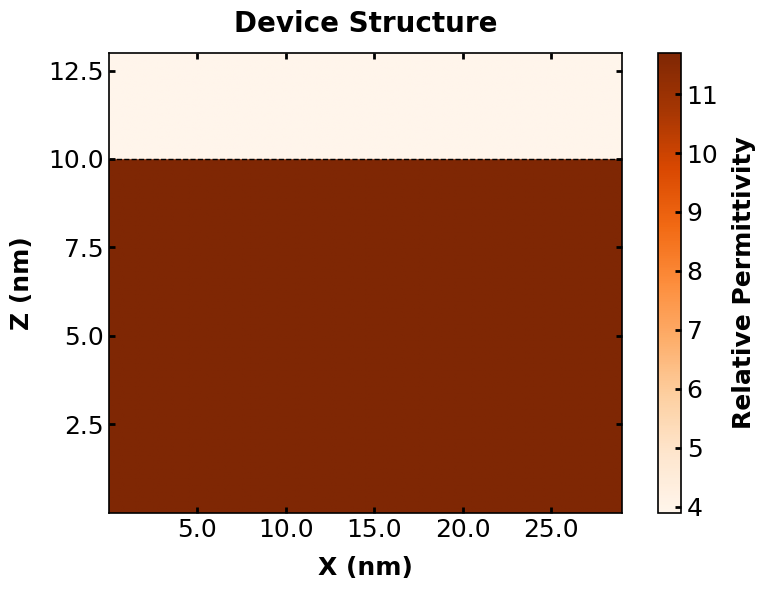

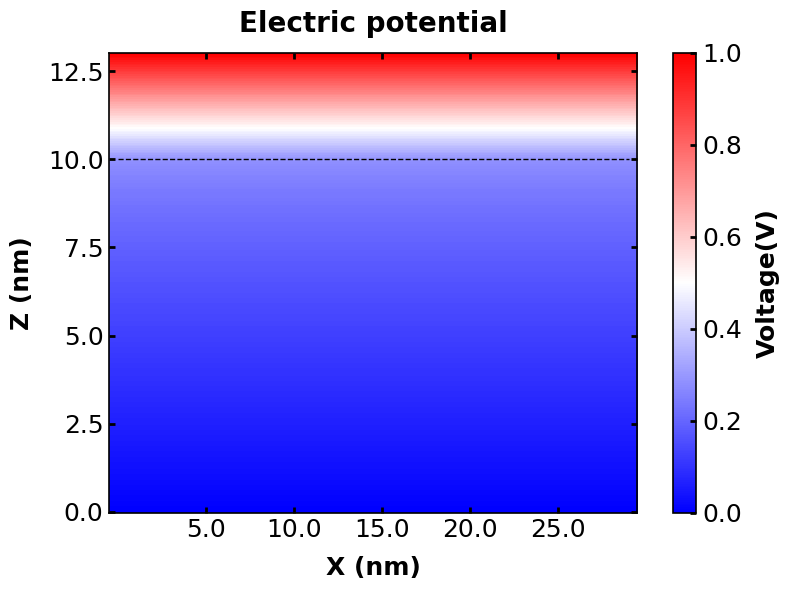

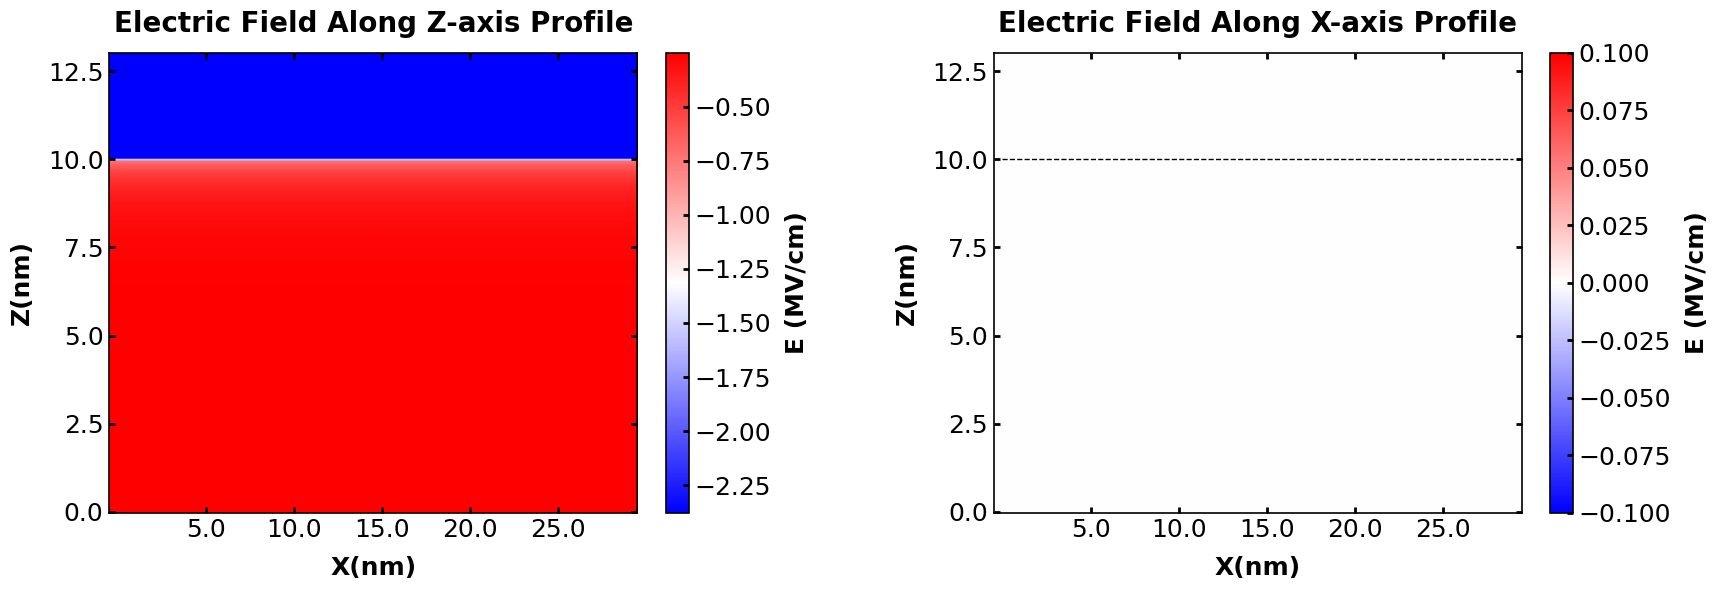

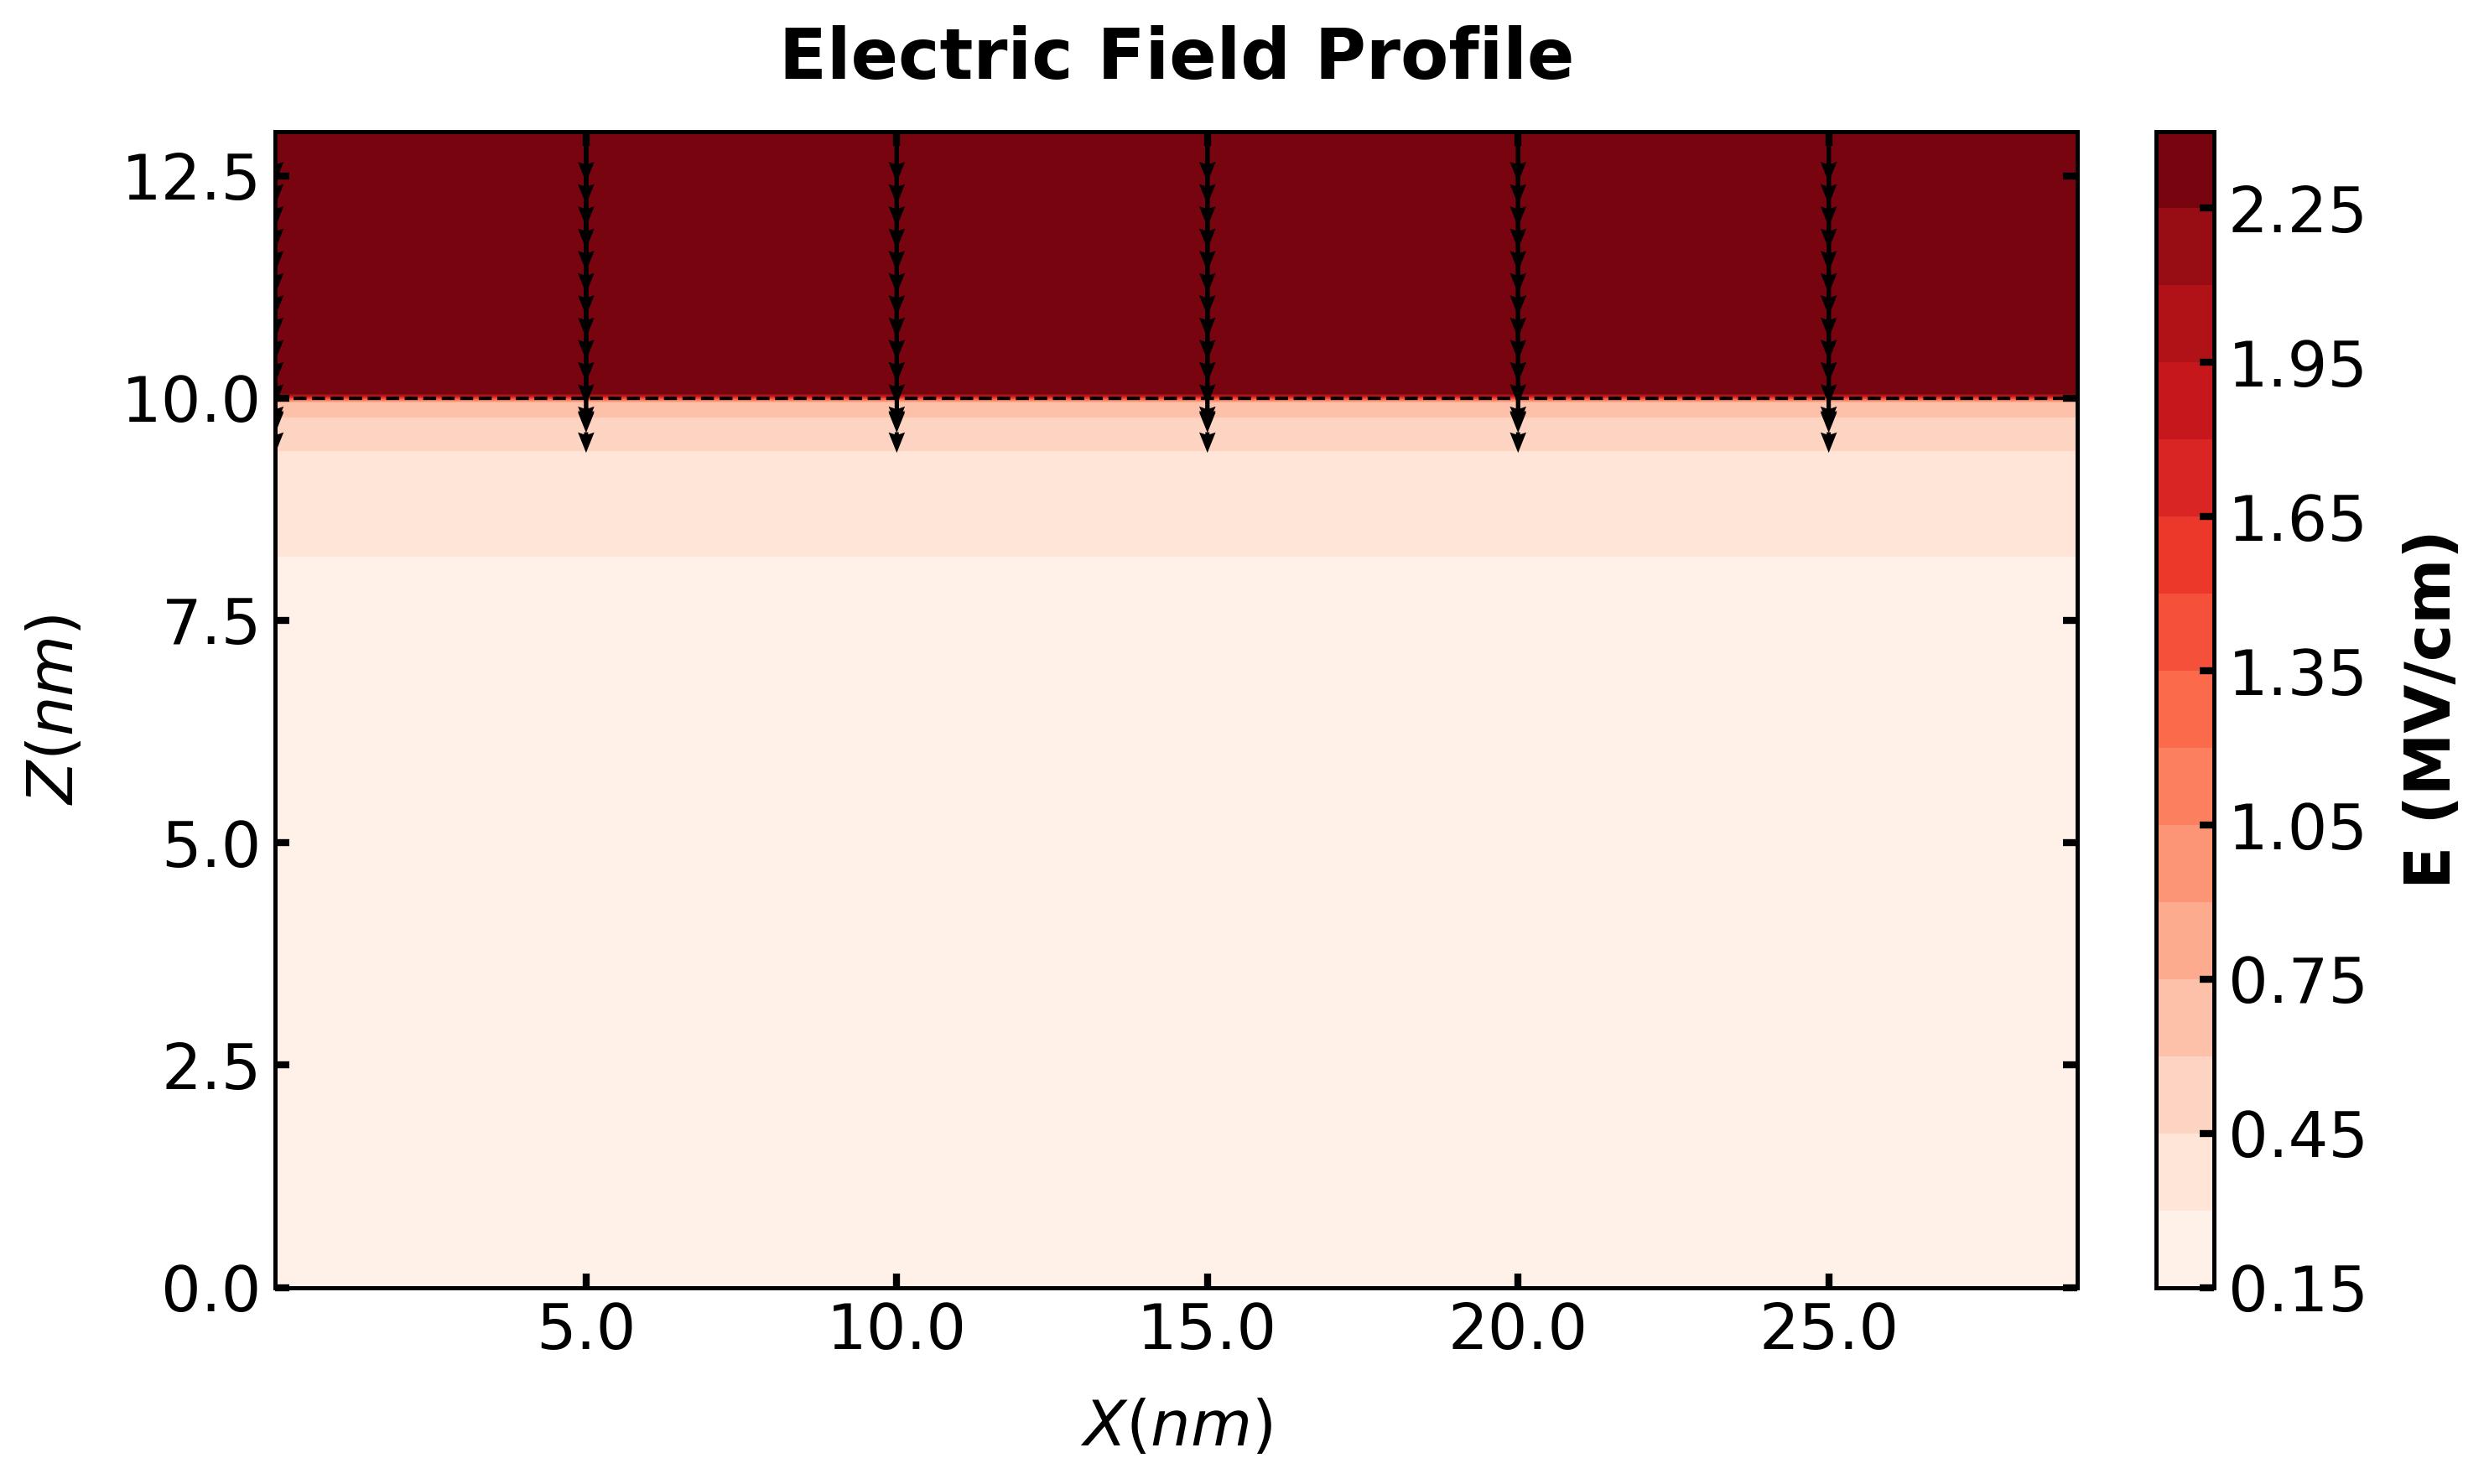

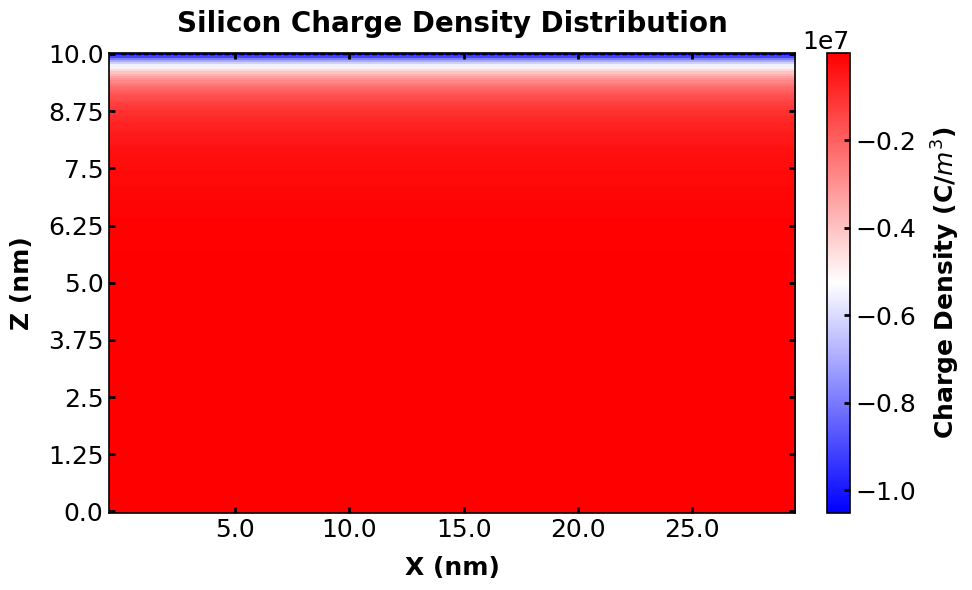

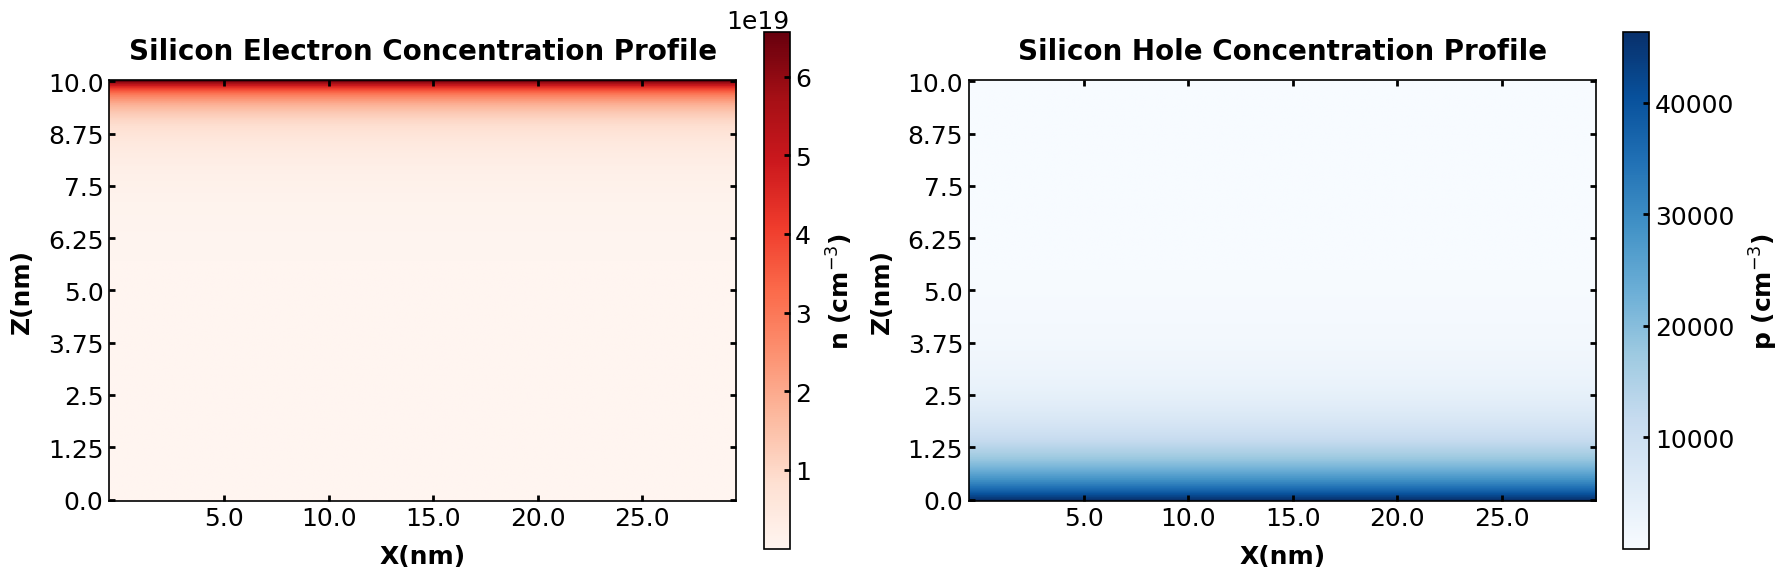

In [11]:
visualizer = DeviceVisualizer(device_params, aspect_ratio=0.1)
visualizer.visualize_permittivity( cmap='Oranges')
visualizer.plot_electric_potential(figsize=(10,6))
visualizer.plot_electric_field(vector_map = True)
visualizer.plot_charge_density()
visualizer.plot_carrier_concentration()

In [12]:
import dolfinx_mpc, inspect
print('dolfinx_mpc top-level attrs:', [a for a in dir(dolfinx_mpc) if 'bc' in a.lower() or 'lift' in a.lower() or 'assemble' in a.lower()])
import dolfinx_mpc.assemble_vector as mpc_av
print('assemble_vector attrs:', [a for a in dir(mpc_av) if 'bc' in a.lower() or 'lift' in a.lower()])

dolfinx_mpc top-level attrs: ['apply_lifting', 'assemble_matrix', 'assemble_matrix_nest', 'assemble_vector', 'assemble_vector_nest']
assemble_vector attrs: ['__init_subclass__', '__subclasshook__']
